# Latent Dirichlet Allocation

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import sklearn
import matplotlib
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), ('Scipy', scipy), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Sklearn Version: 0.19.0


In [179]:
import numpy as np
from string import punctuation

class latent_dirichlet_allocation:
    
    def __init__(self, num_topics=2, num_iter=5, alpha=1, eta=0.001, tokenizer=None, 
                 remove_stopwords=False, verbose=False):
        """
        Latent Dirichlet Allocation is based on the idea of being 
        able to generate documents. The idea is that every doc is 
        made of a series of topics and each topic is made of a 
        series of words. If one wanted to generate a document, we
        could just randomly choose a topic, then choose a word from
        that topic. In practice, we want to do the reverse, which is
        to extract a set of topics given a corpus of docs. To do that
        we'll rely on Gibbs Sampling, which is a Monte Carlo style method
        of assigning every word a topic, then iteratively looping
        through all the words and deciding, what topic is this more likely
        to belong to given what we know about the topics right now using
        a Bayesian understanding of the process. For the process we will
        assume the prior distribution is a Dirichlet distribtution. This
        module also has tokenization built in.
        ---
        KWargs:
        num_topics: how many topics to look for
        num_iter: how many times to iteratively assign topics (more
        iterations leads to better topics, which a decaying return)
        alpha: Hyperparameter that sets information about the 
        Dirichlet prior. In general, the larger this is, the more
        narrow we assume the topics to be and the harder it is to find
        unique topics.
        eta: Hyperparameter that causes more "randomness" to the topic
        distribution while assigning. This causes topics to not get stuck
        in "all the same topic" ruts.
        tokenizer: allows the user to use their own tokenizer. If None,
        uses default tokenizer
        remove_stopwords: flag to choose whether to keep common words or not.
        If False, it will be easy to get topics that are just articles and other
        common words.
        verbose: flag to set level of printing. If True, prints every time a 
        word changes topics.
        """
        self.num_topics = num_topics
        self.num_iter = num_iter
        if tokenizer == None:
            self.tokenizer = self.tokenize
        else:
            self.tokenizer = tokenizer
        self.alpha = alpha
        self.eta = eta
        self.verbose = verbose
        self.remove_stopwords = remove_stopwords
        self.vocabulary = {}
        self.id_to_vocabulary = {}
        self.stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 
                          'there', 'about', 'once', 'during', 'out', 'very', 'having', 
                          'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 
                          'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 
                          'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 
                          'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 
                          'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 
                          'himself', 'this', 'down', 'should', 'our', 'their', 'while', 
                          'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 
                          'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 
                          'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 
                          'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 
                          'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 
                          'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 
                          'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 
                          'was', 'here', 'than'}
        
    def fit(self, X):
        """
        Tokenizes the documents, then creates several lookup
        tables between words and ids. Assigns ever word a random
        topic. Then uses Gibbs sampling to loop through the 
        documents and update the topics assigned to each word
        using Bayes rule and a Dirichlet prior. The Bayes rule
        stuff is tucked in the calculation of p_topics. Once the
        word is updated, updates the data used for choosing word
        topics. 
        """
        # tokenize
        tokenized_docs = [self.tokenizer(x) for x in X]
        
        # create a token to id mapper
        idx = 0
        for doc in tokenized_docs:
            for token in doc:
                if token not in self.vocabulary:
                    self.vocabulary[token] = idx
                    idx += 1
                    
        # create the reverse mapper
        for entry in self.vocabulary.items():
            self.id_to_vocabulary[entry[1]] = entry[0]
        
        # convert docs to ids
        docs_as_ids = []
        token_topics = []
        
        # Setup arrays to store information needed to calculate priors
        # word_topic counts how often each word is assigned to each topic
        # doc_topic counts how much of each topic is in each document
        word_topic = np.zeros((self.num_topics, len(self.vocabulary)))
        doc_topic = np.zeros((len(tokenized_docs), self.num_topics))
        
        # assign a random topic to each token in each document and
        # update the arrays for calculating priors.
        for doc_id, doc in enumerate(tokenized_docs):
            temp_document = []
            temp_topic_assignments = []
            for token in doc:
                random_topic = np.random.randint(0,self.num_topics)
                token_id = self.vocabulary[token]
                temp_document.append(token_id)
                temp_topic_assignments.append(random_topic)
                word_topic[random_topic][token_id] += 1
                doc_topic[doc_id][random_topic] += 1
                
            docs_as_ids.append(temp_document)
            token_topics.append(temp_topic_assignments)
            
        
        # iterative method for doing LDA via Gibbs-Sampling
        for iteration in range(self.num_iter):
            for doc_id, doc in enumerate(docs_as_ids):
                for token_position, token_id in enumerate(doc):
                    # Find the current topic and remove counts from that so a 
                    # word can't vote on what topic itself should be
                    topic_of_token = token_topics[doc_id][token_position]
                    doc_topic[doc_id][topic_of_token] -= 1
                    word_topic[topic_of_token][token_id] -= 1
                    
                    # Calculate the probability of the word belonging
                    # to each topic assuming a Dirichlet Prior for the topics
                    denom_1 = np.sum(doc_topic[doc_id]) + self.alpha*self.num_topics
                    denom_2 = np.sum(word_topic, axis=1) + self.eta*len(self.vocabulary)
                    p_topics = (word_topic[:,token_id]+self.eta)/(denom_2*(doc_topic[doc_id]+self.alpha))/denom_1
                    p_topics = p_topics/np.sum(p_topics)
                    
                    # Given the probs for each topic, randomly choose a topic
                    # weighted by those probabilities
                    new_topic = np.random.multinomial(1, p_topics) #returns an array of size p_topics
                    new_topic = np.argmax(new_topic)
                    
                    # Assign the topic to that word and update all of the
                    # information needed to calculate priors
                    token_topics[doc_id][token_position] = new_topic
                    doc_topic[doc_id][new_topic] += 1
                    word_topic[new_topic][token_id] += 1
                    if topic_of_token != new_topic and self.verbose:
                        print("TOPIC CHANGE for Doc %i, Token %i: %i -> %i"%(doc_id, token_position,
                                                                             topic_of_token, new_topic))
        # Normalize the understanding of the documents and topics to 
        # sum to 1, and store for later usage when converting documents.
        self.doc_topics = self.normalize_by_row(doc_topic)
        self.word_topic = self.normalize_by_row(word_topic)
        
    def normalize_by_row(self, matrix):
        """
        Takes in a matrix of values and normalizes
        such that each row will sum to 1.
        """
        return (matrix.T/np.sum(matrix.T, axis=0)).T
        
    def tokenize(self, X):
        """
        Simple tokenizer that removes punctuation,
        lowercases the text, and breaks on spaces.
        Also removes stopwords and numeric values
        from being treated as words.
        """
        for symbol in punctuation:
            X = X.replace(symbol,'')
        final_token_list = [] 
        for token in X.lower().split():
            if self.remove_stopwords:
                if not self.check_stopwords(token):
                    try:
                        int(token)
                        float(token)
                    except:
                        final_token_list.append(token)  
            else:
                final_token_list.append(token)
        return final_token_list
    
    def check_stopwords(self, token):
        """
        Checks if the token is in our list of common
        stopwords, and returns a boolean.
        """
        return token in self.stopwords
    
    def print_topics(self, num_words_per_topics=10):
        """
        For each topic created in the Gibbs sampling
        find the words that have the largest probability
        of belonging to that topic and print them.
        """
        for idx, row in enumerate(self.word_topic):
            sorted_word_ids = np.argsort(row)[-num_words_per_topics:]
            print("--- Topic ", idx, " ---")
            words_to_print = ""
            for word_id in reversed(sorted_word_ids):
                if self.id_to_vocabulary != None:
                    words_to_print += self.id_to_vocabulary[word_id]
                    words_to_print += ', '
                else:
                    words_to_print += "Column "
                    words_to_print += str(word_id)
                    words_to_print += ', '
            print(words_to_print[:-2])
            
    def transform(self, X):
        """
        Take new set of documents X and figure out how much of 
        each topic they contain.
        """
        
        # tokenize the new documents and create an array
        # to store the amount of each topic in the documents
        tokenized_docs = [self.tokenizer(x) for x in X]
        new_doc_topics = np.zeros((len(X), self.num_topics))
        
        # Loop through documents and tokens in each document
        # add up the "amount" that each token in the doc belongs 
        # to each topic. Return that as the understanding of the
        # new documents in the latent topic space.
        for doc_id, doc in enumerate(tokenized_docs):
            for token in doc:
                try:
                    id_of_token = self.vocabulary[token]
                except KeyError: # if token not in vocab
                    continue
                new_doc_topics[doc_id] += self.word_topic.T[id_of_token]
        new_doc_topics = self.normalize_by_row(new_doc_topics)
        return new_doc_topics
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
                        

In [180]:
from sklearn import datasets

categories = ['alt.atheism', 'comp.graphics', 'rec.sport.baseball']
ng_train = datasets.fetch_20newsgroups(subset='train', 
                                       categories=categories, 
                                       remove=('headers', 
                                               'footers', 'quotes'))
data = ng_train.data

In [211]:
lda = latent_dirichlet_allocation(num_topics=5,num_iter=15, remove_stopwords=True, alpha=.01)
doc_topics = lda.fit(data)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in true_divide


In [212]:
lda.print_topics(num_words_per_topics=10)

--- Topic  0  ---
one, also, another, software, dont, package, right, get, argument, available
--- Topic  1  ---
dont, anyone, data, system, good, however, year, would, time, get
--- Topic  2  ---
one, see, would, im, years, could, jpeg, many, c, god
--- Topic  3  ---
would, files, even, graphics, way, think, like, know, atheists, dont
--- Topic  4  ---
say, good, many, file, image, would, well, people, think, number


/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in true_divide


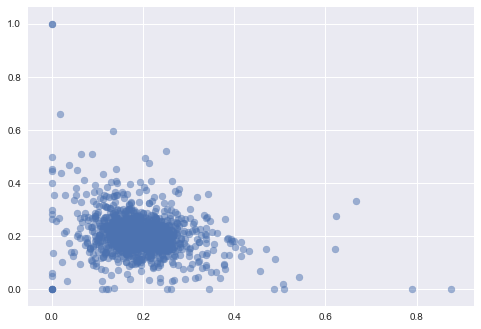

In [213]:
latent_space_documents = lda.transform(data)
plt.scatter(latent_space_documents[:,4],latent_space_documents[:,1], alpha=0.5);

In [217]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X = cv.fit_transform(data)
ld_sk = LatentDirichletAllocation(n_components=5, max_iter=10)
ld_sk.fit(X)

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=5, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

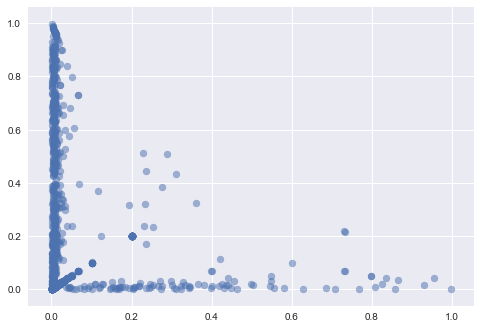

In [218]:
latent_space_documents = ld_sk.transform(X)
plt.scatter(latent_space_documents[:,2],latent_space_documents[:,4], alpha=0.5);

In [219]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
cv_feature_names = cv.get_feature_names()
print_top_words(ld_sk, cv_feature_names, 10)

Topic #0: graphics edu data ftp pub 3d image package available software
Topic #1: year game good 00 team think don games just like
Topic #2: p2 den p3 333 p1 col int radius op_rows op_cols
Topic #3: god people don just does think know like say atheism
Topic #4: image jpeg file color files gif images use program display

